# Chapter 7. Convolution Neural Network

[Remind]<Br>
인접하는 계층의 모든 뉴런과 결합 -> fully-connected (완전연결)<br>
완전연결 계층 -> Affine layer<br>
Affine layer 로 이루어진 5-layer 네트워크의 예: <br>
(input)->(affine)->(ReLU)->(affine)->(ReLU)->(affine)->(ReLU)->(affine)->(ReLU)->(affine)->(softmax)-><br>
<br>


In [29]:
import numpy as np
import sys,os
from collections import OrderedDict
sys.path.append(os.pardir)
from common.util import im2col
from common.layers import *
from common.trainer import Trainer
from dataset.mnist import load_mnist
import pickle
%matplotlib notebook
import matplotlib.pylab as plt

---
## CNN concept

__Fully connected layer의 문제점__<br>
데이터의 형상이 무시된다. 예로, 입력 데이터가 이미지일때 통상 세로,가로,색상 으로 구성된 3차원 데이터를 1차원 데이터로 평탄화해줘야한다. MNIST를 보면 형상이 (1,28,28)인 이미지를 1줄로 세운 784개의 데이터가 첫 affine 계층에 입력된다. <br>
이러한 공간적 정보를 잃는것은 큰 손실이 될 수 있다. 예를 들면 공간적으로 가까운 픽셀은 값이 비슷하거나, RGB의 각 채널은 서로 밀접하게 관련되어 있거나, 거리가 먼 픽셀끼리는 별 연관 없는 등, 3차원 속에서 의미를 갖는 본질적인 패턴이 학습에 있어서 크게 작용할 수 있다. <br>
그러나 완전 연결 계층은 형상을 무시하고 모든 입력 데이터를 동등한 뉴런으로 (같은 차원의 뉴런) 취급하여 형상에 담긴 정보를 살릴 수 없다. <br>
한편 합성곱 계층은 형상을 유지한다. 3차원 데이터로 입력을 받으며 다음 계층에서도 3차원 데이터로 전달한다. 따라서 CNN에서는 이미지처럼 형상을 가진 데이터를 제대로 이해할 것이다. 

__Convolution neural network__<br>
convolution layer 와 pooling layer 가 추가된다. (합성곱 계층, 풀링 계층)<br>
(input)->(Conv->ReLU->Pooling)->(Conv->ReLU->Pooling)->(Conv->ReLU)->(Affine->ReLU)->(Affine->Softmax)-><br>
특징은 다음과 같다. 지금까지의 affine-ReLU구성이 Conv-ReLU-(Pooling)으로 바뀌었다. 풀링 계층은 생략하기도 한다. 또한 출력에 가까운 층에서는 기존의 affine-ReLU 구성을 사용할 수 있다. 또한 마지막 출력계층에서는 affine-softmax 조합을 그대로 사용한다. 이상 일반적인 CNN에서 흔히 볼 수 있는 구성이다. <br>
각 계층 사이에 3차원 데이터같이 입체적인 데이터가 흐른다는 점에서 fully-connected layer 와 다르다. <br><br>
합성곱 계층의 입출력 데이터를 feature map (특징 맵)이라고도 한다. 합성곱 계층의 입력데이터 -> input feature map, 출력 데이터 -> output feature map <br> 


__Convolution in convolution layer__<br>
합성곱 연산은 이미지 처리에서 말하는 필터 연산 (커널)에 해당한다. <br>
구체적 연산 방법 다음 참조: http://cs231n.github.io/convolutional-networks/<br>
필터의 윈도우를 일정 간격 이동해가며 입력 데이터에 적용한다. 입력과 필터에서 대응하는 원소끼리 곱한 후 그 총합을 구한다. 이러한 계산을 fused-multiply-add 라고 한다. 그 결과를 출력의 해당 장소에 저장한다. <br>
CNN에서는 필터의 매개변수가 그동안의 가중치에 해당한다. 편향 또한 존재한다. 편향은 필터를 적용한 후 데이터에 더해진다. 편향은 항상 하나만 존재하며 이 하나의 값이 필터를 적용한 모든 원소에 더해진다. <br>
3차워 합성곱 연산에서는 입력 데이터와 필터의 합성곱 연산을 채널마다 수행하고 그 결과를 더해 하나의 출력을 얻는다. 주의할 점은 입력 데이터의 채널 수와 필터의 채널 수가 같아야한다. 그렇지만 필터 자체의 크기는 원하는 값으로 설정할 수 있다. <br>
3차원 합성곱 연산은 데이터와 필터를 직육면체 블록이라 생각하면 쉽다. 다수의 필터를 적용하면 output feature map 또한 다수로 생성된다. 필터를 FN개 적용하면 출력 맵도 FN개 생성되며 그 FN개의 맵을 모으면 형상이 (FN,OH,OW)인 블록이 완성된다. 이 완성된 블록을 다음 계층으로 넘기겠다는 것이 CNN의 처리 흐름이다. 필터의 가중치 데이터는 4차원 데이터이며 (출력 채널수, 입력 채널 수, 높이, 너비) 순으로 쓴다. 예로 채널 수 3, 크기 5*5인 필터가 20개 있으면 (20,3,5,5)로 쓴다. <br>
편향은 채널 하나에 값 하나씩 구성. 형상은 (FN,OH,OW). <Br>
마찬가지로 배치 처리를 지원할 수 있다. 각 계층을 흐르는 데이터의 차원을 하나 늘려 (데이터 수, 채널 수, 높이, 너비) 순으로 저장할 수 있다. 따라서 배치 처리 시 데이터는 4차원 형상을 가진 채 각 계층을 타고 흐른다. 주의할 점은 신경망에 4차원 데이터가 하나 흐를 때마다 데이터 N개에 대한 합성곱 연산이 이뤄진다. 즉 N회 분의 처리를 한 번에 수행한다. 

__Padding__<br>
합성곱 연산을 수행하기 전 입력 데이터 주변을 특정 값 (보통 0) 으로 채운다. 이를 패딩이라 하며 합성곱 연산에서 자주 이용된다. <br>
주로 출력 크기를 조정할 목적으로 사용한다. 합성곱 연산을 거칠 때마다 크기가 작아지면 어느 시점에선 출력 크기가 1이 되어버려 더이상 합성곱 연산을 진행 할 수 없다. 이를 방지하고자 패딩을 이용해 입력 데이터의 공간적 크기를 고정한 채로 다음 계층에 전달 할 수 있다. 

__Stride__<br>
필터를 적용하는 위치의 간격을 스트라이드라 한다. <br>


__출력 크기 계산식__<br>
입력크기: (H,W)<br>
필터크기: (FH,FW)<br>
출력크기: (OH,OW)<br>
패딩: P<br>
스트라이드: S<br>
$$OH=\frac{H+2P-FH}{S}+1$$
$$OW=\frac{W+2P-FW}{S}+1$$
위 식에서 항상 S로 나눌 때 정수가 되어야한다는 점에 주의하자. 출력 크기가 정수가 아니면 오류를 내는 등의 대응을 해줘야한다. 또는 가까운 정수로 반올림하는 등의 구현도 가능하다. 

__Pooling layer__<br>
세로 가로 방향의 공간을 줄이는 연산, 대표적으로 max pooling, average pooling 이 있다. 이미지 인식 분야에서는 주로 max pooling 사용<br>
특징으로 첫째, 학습해야 할 매개변수가 없다. 명확한 처리를 하여 특별히 학습할 것이 없다. 둘째, 채널 수가 변하지 않는다. 입력 데이터의 채널 수 그대로 출력 데이터로 내보낸다. 셋째, 입력의 변화에 영향을 적게 받는다. 입력 데이터가 조금 변해도 풀링의 결과는 잘 변하지 않는다. 특히 max pooling 은 스트라이드 내 최댓값이 변하지 않는 이상 다른 입력 데이터가 변해도 그대로임을 알 수 있다. 

---
## CNN 구현
CNN은 4차원 데이터를 다룬다. 합성곱 연산을 곧이곧대로 구현하려면 for문을 겹겹이 써야할 것이다. 하지만 for 문을 사용하면 성능이 떨어진다는 단점이 있다. 넘파이에서는 원소 접근시 for 문을 사용하지 않는 것이 바람직하다. 따라서 for 문 대신 im2col이라는 편의 함수를 사용해 간단하게 구현해보자.

__im2col__<br>
im2col은 입력 데이터를 필터링 (가중치 계산) 하기 좋게 전개하는 함수이다. 3차원 입력 데이터에 im2col을 적용하면 2차원 행렬로 바뀐다. 정확히는 배치 안의 데이터 수까지 포함하면 4차원 데이터를 2차원으로 변환한다. 5번그림 참조<br>
입력데이터에서 필터를 적용하는 영역을 한 줄로 늘어놓는다. 이 전개를 필터를 적용하는 모든 영역에서 수행하는게 im2col이다. <br>
일반적으로 스트라이드를 설정했을때 필터 적용 영역이 겹치게 된다. 따라서 im2col로 전개 후의 원소 수가 원래 블록의 원소 수보다 많아진다. 그래서 im2col을 사용해 구현하면 메모리를 더 많이 소비하는 단점이 있다. 하지만 컴퓨터는 큰 행렬을 묶어서 계산하는데 탁월하다. 예를 들어 행렬 계산 라이브러리 등은 행렬 계산에 고도로 최적화되어 큰 행렬의 곱셈을 빠르게 할 수 있다. 그래서 문제를 행렬 계산으로 만들면 선형 대수 라이브러리를 활용해 효율을 높일 수 있다.<br>
im2col로 입력 데이터를 전개한 다음 합성곱 계층의 필터를 1열로 전개하고 두 행렬의 내적을 계산하면 된다. im2col 방식으로 출력한 결과는 2차원 행렬이다. CNN은 데이터를 4차원 배열로 저장하므로 2차원인 출력 데이터를 4차원으로 reshape한다. 6번그림 참조.<br>


In [28]:
# im2col(input_data,filter_h,filter_w,stride=1,pad=0)

배치 크기 1 (데이터 1개), 채널 3개, 높이*너비=7*7

In [9]:
x1=np.random.rand(1,3,7,7) # (데이터수, 채널수, 높이, 너비)
col1=im2col(x1,5,5,stride=1,pad=0)
print(col1.shape)

(9, 75)


배치 크기 10 (데이터 10개), 채널 3개, 높이*너비=7*7

In [7]:
x2=np.random.rand(10,3,7,7) # 데이터수: 10개
col2=im2col(x2,5,5,stride=1,pad=0)
print(col2.shape)

(90, 75)


두 경우 모두 2번째 차원의 원소는 75개이다. 이는 필터의 원소 수와 같다. (채널 3개, 5*5 필터)<Br>
배치 크기 1일때 im2col 결과 크기가 (9,75)이고, 배치 크기 10일때 10배인 (90,75) 크기의 데이터가 저장된다.

__im2col을 이용한 convolution layer 구현__<br>


In [11]:
class Convolution:
    def __init__(self,W,b,stride=1,pad=0):
        self.W=W
        self.b=b
        self.stride=stride
        self.pad=pad
        
    def forward(self,x):
        FN,C,FH,FW=self.W.shape
        N,C,H,W=x.shape
        out_h=int(1+(H+2*self.pad-FH)/self.stride)
        out_w=int(1+(W+2*self.pad-FW)/self.stride)
        
        col=im2col(x, FH, FW, self.stride, self.pad)
        col_W=self.W.reshape(FN,-1).T # 필터 전개
        out=np.dot(col,col_W)+self.b
        
        out=out.reshape(N,out_h,out_w,-1).transpose(0,3,1,2)
        
        return out

Convolution layer class 설명<br>
합성곱 계층은 필터(가중치), 편향, 스트라이드, 패딩을 인수로 받아 초기화 한다. <br>
필터는 (FN, C, FH, FW) 의 4차원 형상이다. FN: 필터개수, C: 채널, FH: 필터높이, FW: 필터 너비<br>
입력 데이터를 im2col로 전개하고 필터도 reshape 를 사용해 2차원 배열로 전개한다. 이렇게 전개한 두 행렬의 내적을 구한다.<br>
필터를 전개하는 부분에서 각 필터의 블록은 1줄로 펼쳐진다. reshape에서 -1 옵션은 다차원 배열의 원소 수가 변환 후에도 똑같이 유지되도록 적절히 묶어준다. 예를 들면 (10,3,5,5) 총 750개 원소를 가지는 배열에 reshape(10,-1)을 하면 형상이 (10,75)인 배열로 만들어준다. <br>
다음으로 forward 구현의 마지막에서는 출력 데이터를 적절한 형상으로 바꿔준다. transpose함수를 사용해 다차원 배열의 축 순서를 바꿔준다. <br>
im2col로 전개한 덕분에 affine 계층과 거의 똑같이 구현할 수 있다. 역전파 또한 affine 계층의 구현과 공통점이 많다. 주의할 점은 역전파에선 im2col을 역으로 처리해야한다. col2im 함수 참조. col2im 을 사용한다는 점을 제외하면 합성곱 계층의 역전파는 affine 계층과 똑같다. 

__pooling layer 구현__<br>

In [12]:
class Pooling:
    def __init__(self,pool_h,pool_w,stride=1,pad=0):
        self.pool_h=pool_h
        self.pool_w=pool_w
        self.stride=stride
        self.pad=pad
    def forward(self,x):
        N,C,H,W=x.shape
        out_h=int(1+(H-self.pool_h)/self.stride)
        out_w=int(1+(W-self.pool_w)/self.stride)
        
        col=im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col=col.reshape(-1,self.pool_h*self.pool_w)
        
        out=np.max(col,axis=1)
        
        out=out.reshape(N,out_h,out_w,C).transpose(0,3,1,2)
        
        return out

pooling layer class 설명:<br>
입력 데이터 전개 -> 행렬 최댓값 구함 -> 적절한 모양으로 reshape<br>
pooling layer 의 backward 처리는 ReLU 계층에서의 max 역전파를 참고

__최종 CNN 구현__<br>
SimpleConvNet: Conv->ReLU->Pooling->Affine->ReLU->Affine->Softmax

In [24]:
class SimpleConvNet:
    def __init__(self,input_dim=(1,28,28),conv_param={'filter_num':30,'filter_size':5,'pad':0,'stride':1},
                hidden_size=100,output_size=10,weight_init_std=0.01):
        filter_num=conv_param['filter_num']
        filter_size=conv_param['filter_size']
        filter_pad=conv_param['pad']
        filter_stride=conv_param['stride']
        input_size=input_dim[1]
        conv_output_size=(input_size-filter_size+2*filter_pad)/filter_stride+1
        pool_output_size=int(filter_num*(conv_output_size/2)*(conv_output_size/2))
        
        self.params={}
        self.params['W1']=weight_init_std*np.random.randn(filter_num,input_dim[0],filter_size,filter_size)
        self.params['b1']=np.zeros(filter_num)
        self.params['W2']=weight_init_std*np.random.randn(pool_output_size,hidden_size)
        self.params['b2']=np.zeros(hidden_size)
        self.params['W3']=weight_init_std*np.random.randn(hidden_size,output_size)
        self.params['b3']=np.zeros(output_size)
        
        self.layers=OrderedDict()
        self.layers['Conv1']=Convolution(self.params['W1'],self.params['b1'],conv_param['stride'],conv_param['pad'])
        self.layers['Relu1']=Relu()
        self.layers['Pool1']=Pooling(pool_h=2,pool_w=2,stride=2)
        self.layers['Affine1']=Affine(self.params['W2'],self.params['b2'])
        self.layers['Relu2']=Relu()
        self.layers['Affine2']=Affine(self.params['W3'],self.params['b3'])
        self.last_layer=SoftmaxWithLoss()
    
    def predict(self,x):
        for layer in self.layers.values():
            x=layer.forward(x)
        return x

    def loss(self,x,t):
        y=self.predict(x)
        return self.last_layer.forward(y,t)
    
    def gradient(self,x,t):
        # forward
        self.loss(x,t)
        
        # backward
        dout=1
        dout=self.last_layer.backward(dout)
        layers=list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout=layer.backward(dout)
            
        # save grad
        grads={}
        grads['W1']=self.layers['Conv1'].dW
        grads['b1']=self.layers['Conv1'].db
        grads['W2']=self.layers['Affine1'].dW
        grads['b2']=self.layers['Affine1'].db
        grads['W3']=self.layers['Affine2'].dW
        grads['b3']=self.layers['Affine2'].db
        
        return grads
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 

        return acc / x.shape[0]
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [23]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()



train loss:2.30101478112
=== epoch:1, train acc:0.271, test acc:0.279 ===
train loss:2.29902091698
train loss:2.29633603212
train loss:2.2889822945
train loss:2.28765752862
train loss:2.28197586587
train loss:2.27064586945
train loss:2.24752080451
train loss:2.24208721859
train loss:2.20839175768
train loss:2.19335240506
train loss:2.15649281189
train loss:2.1592775224
train loss:2.10284903817
train loss:2.06816767581
train loss:1.96488681767
train loss:1.98965837151
train loss:1.8939323743
train loss:1.82613678865
train loss:1.76708915796
train loss:1.68709462325
train loss:1.56550403149
train loss:1.58956366246
train loss:1.42694226871
train loss:1.26535795689
train loss:1.25445653559
train loss:1.18923290682
train loss:1.13033074394
train loss:1.00404264229
train loss:0.970487105206
train loss:0.948989809102
train loss:0.836772599671
train loss:0.79129530507
train loss:0.818813312844
train loss:0.801512133975
train loss:0.832107150377
train loss:0.552897143355
train loss:0.650916750

NameError: name 'pickle' is not defined

Saved Network Parameters!


<IPython.core.display.Javascript object>


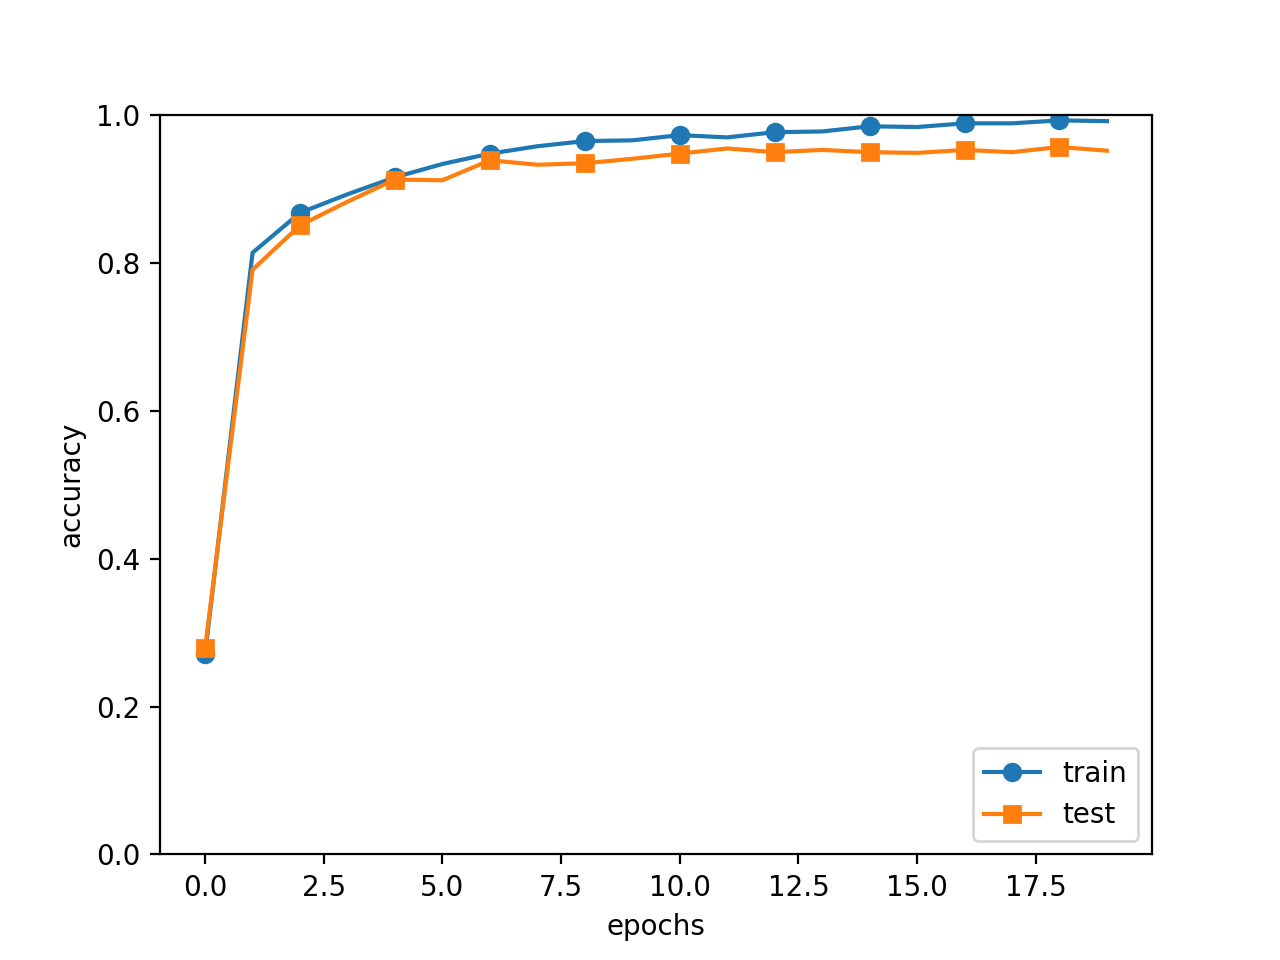

In [27]:
# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")


# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

---
## CNN visualization


<IPython.core.display.Javascript object>


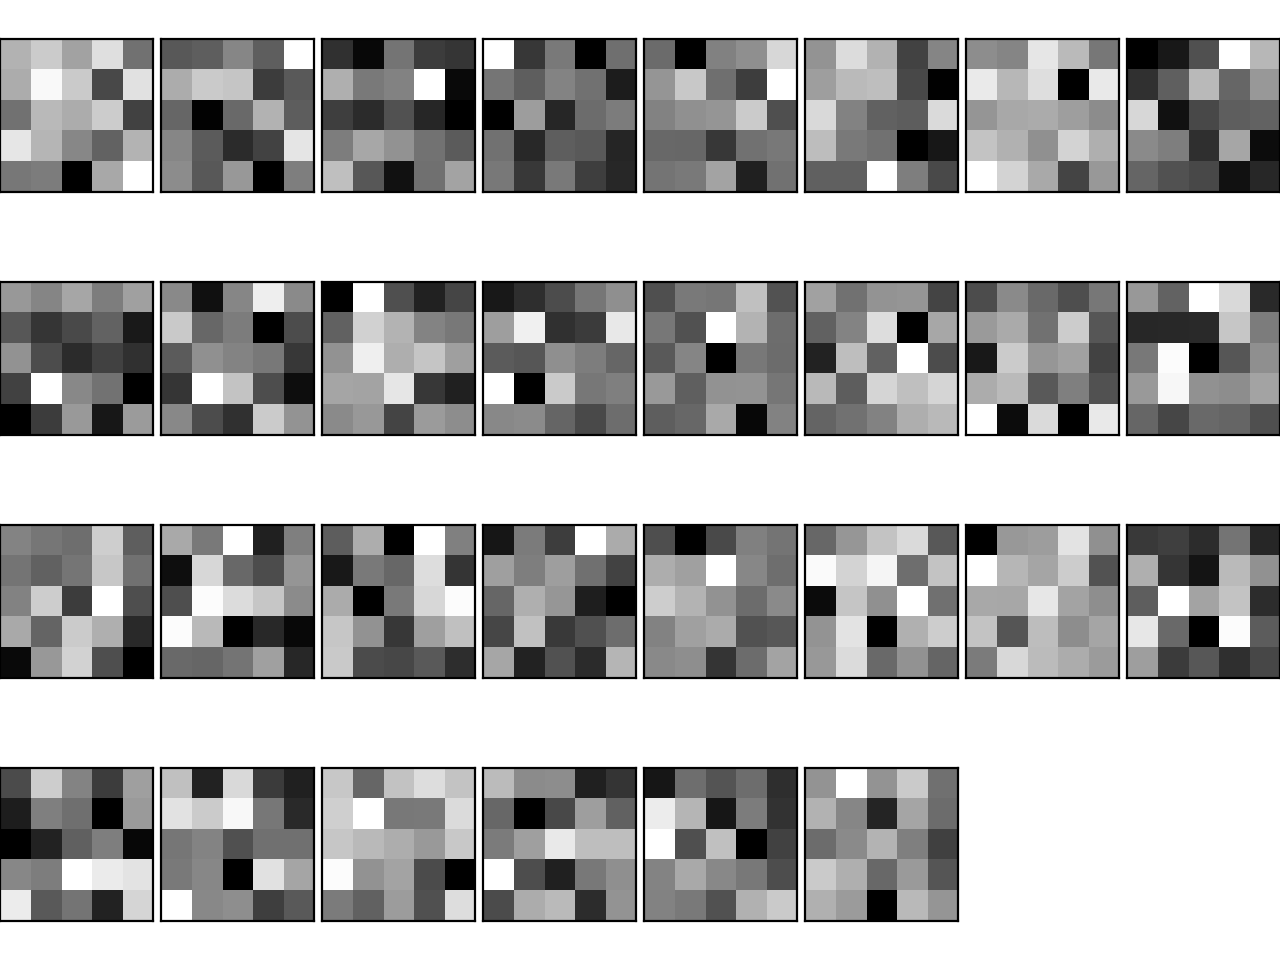

<IPython.core.display.Javascript object>


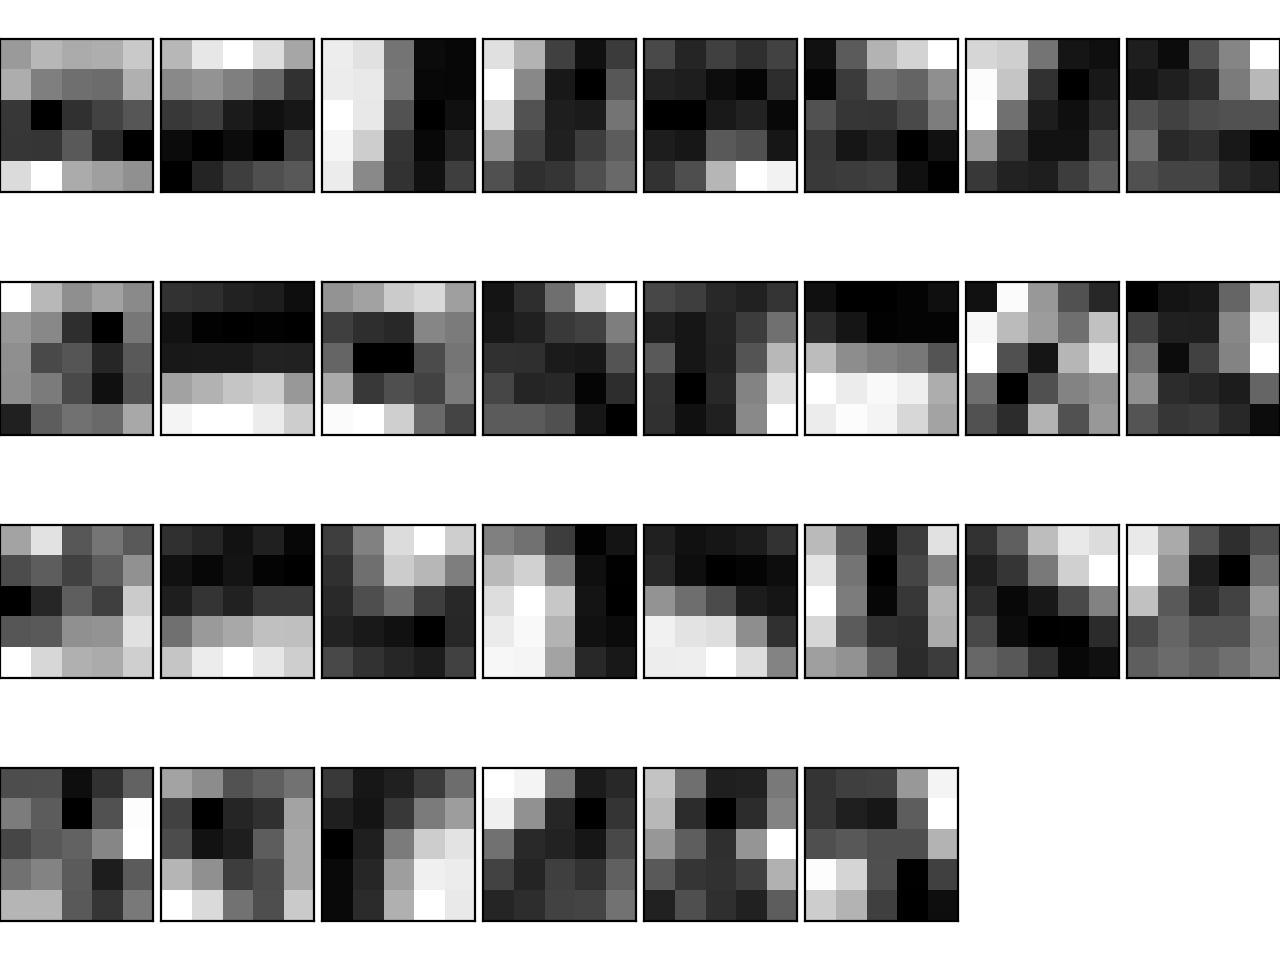

In [30]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])

앞의 MNIST CNN 학습에서, 1번째 층의 합성곱 계층의 가중치는 (30,1,5,5) 형상을 가졌다. (필터 30개, 채널 1개, 5*5 크기)<br>
이는 이 필터를 1채널의 회색조 이미지로 시각화 할 수 있다는 뜻이다. 이 1번째 합성곱 계층을 이미지로 나타낼 수 있다. <br>
위의 그림은 학습 전과 후의 1번째 층의 합성곱 계층의 가중치를 시각화한 것이다. 학습 전 필터는 무작위로 초기화되고 있어 규칙적이 없는 반면 학습 후 필터는 규칙성 있는 이미지가 되었다. 엣지 (색상이 바뀐 경계선)와 블롭 (국소적으로 덩어리진 영역) 등의 규칙이 보인다. 이처럼 합성곱 계층의 필터는 엣지나 블롭 등 원시적인 정보를 추출할 수 있다. 이런 원시적인 정보가 차후 계층에 전달된다는 것이 CNN에서 일어나는 일이다. 

계층이 깊어질수록 추출되는 정보는 더 추상화된다고 한다. 정확히 말하면 강하게 반응하는 뉴런이 점점 더 복잡하고 추상화 된다는 것이다. AlexNet 결과를 보면 처음 층은 단순한 에지에 반응하고, 이어서 텍스처, 더 복잡한 사물의 일부에 반응하도록 변화한다. 즉 층이 깊어지면서 뉴런이 반응하는 대상이 단순한 모양에서 고급 정보로 변화해간다. 다시 말하면 사물의 의미를 이해하도록 변화하는 것이다. 

---
## 대표적인 CNN 

첫 CNN은 20년 전 제안된 LeNet이다. 이는 합성곱 계층과 폴링 계층 (정확히는 단순히 원소를 줄이는 서브샘플링 계층)을 반복하고 마지막 완전연결 계층을 거치며 결과를 출력한다. 현재 CNN과 비교했을때 활성화함수를 시그모이드 함수로 썼다는 점 (현재는 주로 ReLU), 서브샘플링하여 중간 데이터의 크기를 작아지게 했다는 점 (현재는 주로 맥스 풀링)을 들 수 있다. <br>
딥러닝 열풍을 일으킨 AlexNet은 2012년에 발표되었다. 이는 LeNet와 크게 다르진 않지만 다음에서 차이를 보인다. 첫째, 활성함수로 ReLU를 사용. 둘째, local response normalization이라는 국소적 정규화를 실시하는 계층을 이용, 셋째 드롭아웃 사용. 네트워크 구성 면에선 LeNet과 큰 차이가 없으나 이를 둘러싼 환경과 컴퓨터 기술이 큰 진보를 이루었다. 대량의 데이터를 누구나 얻을 수 있게 되었고 병렬 계산에 특화된 GPU가 보급되면서 대량 연산을 고속으로 수행할 수 있게 되었다. 빅데이터와 GPU, 이것이 딥러닝 발전의 큰 원동력이다. <br>
딥러닝에선 대부분 수많은 매개변수가 쓰인다. 따라서 학습을 위해 엄청난 양의 계산이 필요하다. 또한 그 매개변수를 fitting 시키는 데이터도 대량으로 필요하다. GPU와 빅데이터는 이런 문제에 해결책을 주었다 말할 수 있다. 

---
## Chapter 7 정리
    * CNN은 지금까지의 fully-connected network 에 convolution&pooling layer 를 새로 추가한다.
    * 합성곱 계층과 풀링 계층은 im2col(이미지를 행렬로 전개하는 함수)를 이용하면 더 간단하고 효율적으로 구현할 수 있다.
    * CNN 시각화시 계층이 깊어질수록 고급 정보가 추출되는 모습을 확인할 수 있다.
    * 대표적 CNN으로 LeNet과 AlexNet이 있다.
    * 딥러닝 발전에 빅데이터와 GPU가 크게 기여했다.